# This notebook provides the statistics of the datsets

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import numpy as np
import pandas as pd
import sys
import os
import glob
import imageio
import time
from scipy import ndimage, signal
from cv2 import medianBlur

sys.path.append("..")

from PIL import Image
from costum_arild.source.utils import image_processing_utils, gdal_utils
from costum_arild.source.data_processing import TrainingImage

2023-02-27 12:18:36.701667: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
def class_count_list_dataframe(class_count_list, unknown_zero):
    class_df = pd.DataFrame(class_count_list, dtype='float32')

    class_df.loc['class_sum'] = class_df.sum(axis=0)

    if unknown_zero == True:
        class_df = class_df.rename(columns={5: "water", 1: "gravel", 2: "vegetation", 3: "farmland", 4: "h_c", 0: "unknown"})
    else:
        class_df = class_df.rename(columns={0: "water", 1: "gravel", 2: "vegetation", 3: "farmland", 4: "h_c", 5: "unknown"})

    class_df.loc['class_sum_percent'] = ((class_df.loc['class_sum'] / class_df.loc['class_sum'].sum()) * 100)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    return class_df

In [4]:
dest_save = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/plots/dataset_statistics'

# new image

### ex1

the first version of dataset

In [8]:
new_dataset = None

In [9]:
all_lbl_path_train = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/train/label/img'
all_lbl_path_val = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/val/label/img'
all_lbl_path_test = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/test/label/img'

all_lbl_class_count_train = image_processing_utils.count_class_list_directory_2d(all_lbl_path_train)
all_lbl_class_count_val = image_processing_utils.count_class_list_directory_2d(all_lbl_path_val)
all_lbl_class_count_test = image_processing_utils.count_class_list_directory_2d(all_lbl_path_test)

In [10]:
all_lbl_class_count = all_lbl_class_count_train + all_lbl_class_count_val + all_lbl_class_count_test

all images

In [11]:
unknown_zero = True
all_class_df = class_count_list_dataframe(class_count_list=all_lbl_class_count, unknown_zero=unknown_zero)
new_dataset = all_class_df.loc['class_sum_percent'].to_frame()
new_dataset = new_dataset.rename(columns={"class_sum_percent": "initial"})

all_class_df.loc['class_sum_percent'].to_frame()

,class_sum_percent
unknown,0.59
gravel,2.10
vegetation,62.20
farmland,26.32
h_c,4.13
water,4.66


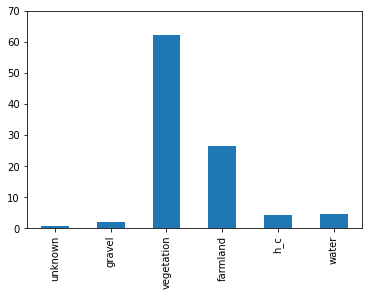

In [14]:
plot = new_dataset.plot.bar(legend=False)
fig = plot.get_figure()
plot.set_ylim(0,70)
fig.savefig( os.path.join(dest_save, 'normal_sampling.png'))

training images

In [9]:
unknown_zero = True
all_class_df = class_count_list_dataframe(class_count_list=all_lbl_class_count_train, unknown_zero=unknown_zero)
all_class_df.loc['class_sum_percent'].to_frame()

,class_sum_percent
unknown,0.60
gravel,2.13
vegetation,62.53
farmland,26.12
h_c,4.09
water,4.52


### ex2

In [5]:
all_lbl_path_train = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex2_images/train/label/img'
all_lbl_path_val = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/val/label/img'
all_lbl_path_test = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/test/label/img'

all_lbl_class_count_train = image_processing_utils.count_class_list_directory_2d(all_lbl_path_train)
all_lbl_class_count_val = image_processing_utils.count_class_list_directory_2d(all_lbl_path_val)
all_lbl_class_count_test = image_processing_utils.count_class_list_directory_2d(all_lbl_path_test)

In [6]:
all_lbl_class_count = all_lbl_class_count_train + all_lbl_class_count_val + all_lbl_class_count_test

In [7]:
unknown_zero = True
all_class_df = class_count_list_dataframe(class_count_list=all_lbl_class_count, unknown_zero=unknown_zero)
new_dataset['rotated'] = all_class_df.loc['class_sum_percent'].to_frame()

all_class_df.loc['class_sum_percent'].to_frame()

NameError: name 'new_dataset' is not defined

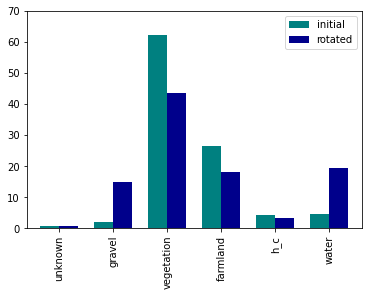

In [19]:
plot = new_dataset.plot.bar(color=['teal', 'darkblue'], width=0.7)
fig = plot.get_figure()
plot.set_ylim(0,70)
fig.savefig( os.path.join(dest_save, 'new_dataset.png'))

In [37]:
new_dataset = new_dataset[-1:] + new_dataset[:-1]

NameError: name 'new_dataset' is not defined

# Old dataset

### ex1

In [20]:
old_dataset = None

In [21]:
def count_class_list_directory_2d_tif(src_label_path, verbose=0):
    """ returns list of vectors in which number of classes of one image is mentioned (2d)"""
    class_count_list = []
    start = time.time()
    for label_path in glob.glob(os.path.join(src_label_path, '*.tif')):
        if verbose == 1:
            print(f'working on label {os.path.split(label_path)[-1]}')

        # read label
        original_label_matrix = imageio.imread(label_path)

        if original_label_matrix.shape[-1] != 3:
            # it is not a 3 channel label so we can calculate the class info
            # get the information about the classes
            (unique_tmp, counts_tmp) = np.unique(
                original_label_matrix, return_counts=True)
            class_count_vec = np.zeros(6)
            class_count_vec[unique_tmp] = counts_tmp
            class_count_list.append(class_count_vec)
        else:
            raise NotImplementedError('it is not 2d')

    end = time.time()
    if verbose == 1:
        print(f'the time takes {end - start}')
    return class_count_list

In [22]:
all_lbl_path_train = '/home/saeid/phd/segmentation/dataset/machine_learning_dataset/train/labels'
all_lbl_path_val = '/home/saeid/phd/segmentation/dataset/machine_learning_dataset/val/labels'
# all_lbl_path_test = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/test/label/img'

all_lbl_class_count_train = count_class_list_directory_2d_tif(all_lbl_path_train)
all_lbl_class_count_val = count_class_list_directory_2d_tif(all_lbl_path_val)
# all_lbl_class_count_test = image_processing_utils.count_class_list_directory_2d(all_lbl_path_test)

In [23]:
all_lbl_class_count = all_lbl_class_count_val + all_lbl_class_count_train

all images

In [24]:
unknown_zero = False
all_class_df_old = class_count_list_dataframe(class_count_list=all_lbl_class_count, unknown_zero=unknown_zero)
all_class_df_old.loc['class_sum_percent'].to_frame()

old_dataset = all_class_df_old.loc['class_sum_percent'].to_frame()
old_dataset = old_dataset.rename(columns={"class_sum_percent": "initial"})

train

<AxesSubplot:>

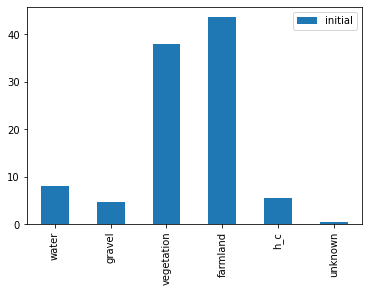

In [25]:
old_dataset.plot.bar()

### ex2

In [26]:
all_lbl_path_train = '/media/saeid/ADATA HD710/NTNU/PHD/old dataset/rotation_augmentation/train/label/img'
all_lbl_path_val = '/media/saeid/ADATA HD710/NTNU/PHD/old dataset/rotation_augmentation/val/label/img'

all_lbl_class_count_train = image_processing_utils.count_class_list_directory_2d(all_lbl_path_train)
all_lbl_class_count_val = image_processing_utils.count_class_list_directory_2d(all_lbl_path_val)

In [27]:
all_lbl_class_count = all_lbl_class_count_val + all_lbl_class_count_train

In [28]:
unknown_zero = False
all_class_df_old = class_count_list_dataframe(class_count_list=all_lbl_class_count, unknown_zero=unknown_zero)
all_class_df_old.loc['class_sum_percent'].to_frame()

old_dataset['rotated'] = all_class_df_old.loc['class_sum_percent'].to_frame()

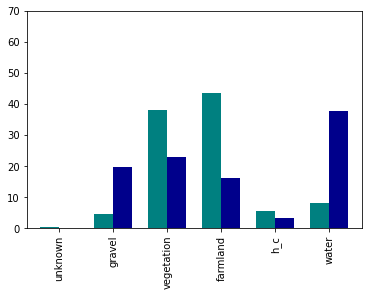

In [29]:
old_dataset = old_dataset.reindex(index = ['unknown','gravel', 'vegetation', 'farmland', 'h_c', 'water'])
plot = old_dataset.plot.bar(color=['teal', 'darkblue'], width=0.7, legend=False)
fig = plot.get_figure()
plot.set_ylim(0,70)
fig.savefig( os.path.join(dest_save, 'old_dataset_nolegend.png'))

In [ ]:
old_dataset